In [3]:
# pip install pydotplus
# pip install graphviz

In [4]:
# import necessary modules
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary
import pydotplus
import graphviz

# 1. Classification Tree

## Example 1: Riding movers owners

Classes: Nonowner, Owner


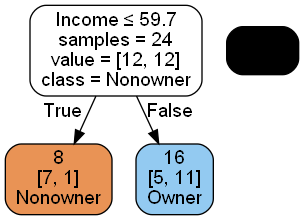

In [5]:
mover_df = pd.read_csv('../DATA/RidingMowers.csv')
# use max_depth to control tree size (None = Full Tree)
classTree = DecisionTreeClassifier(random_state=0, max_depth=1)
classTree.fit(mover_df.drop(columns=['Ownership']), mover_df['Ownership'])
print("Classes: {}".format(', '.join(classTree.classes_)))
plotDecisionTree(classTree, feature_names=mover_df.columns[:2],
                 class_names=classTree.classes_)

## Example 2: Acceptance of Personal Loan

### Full grown tree

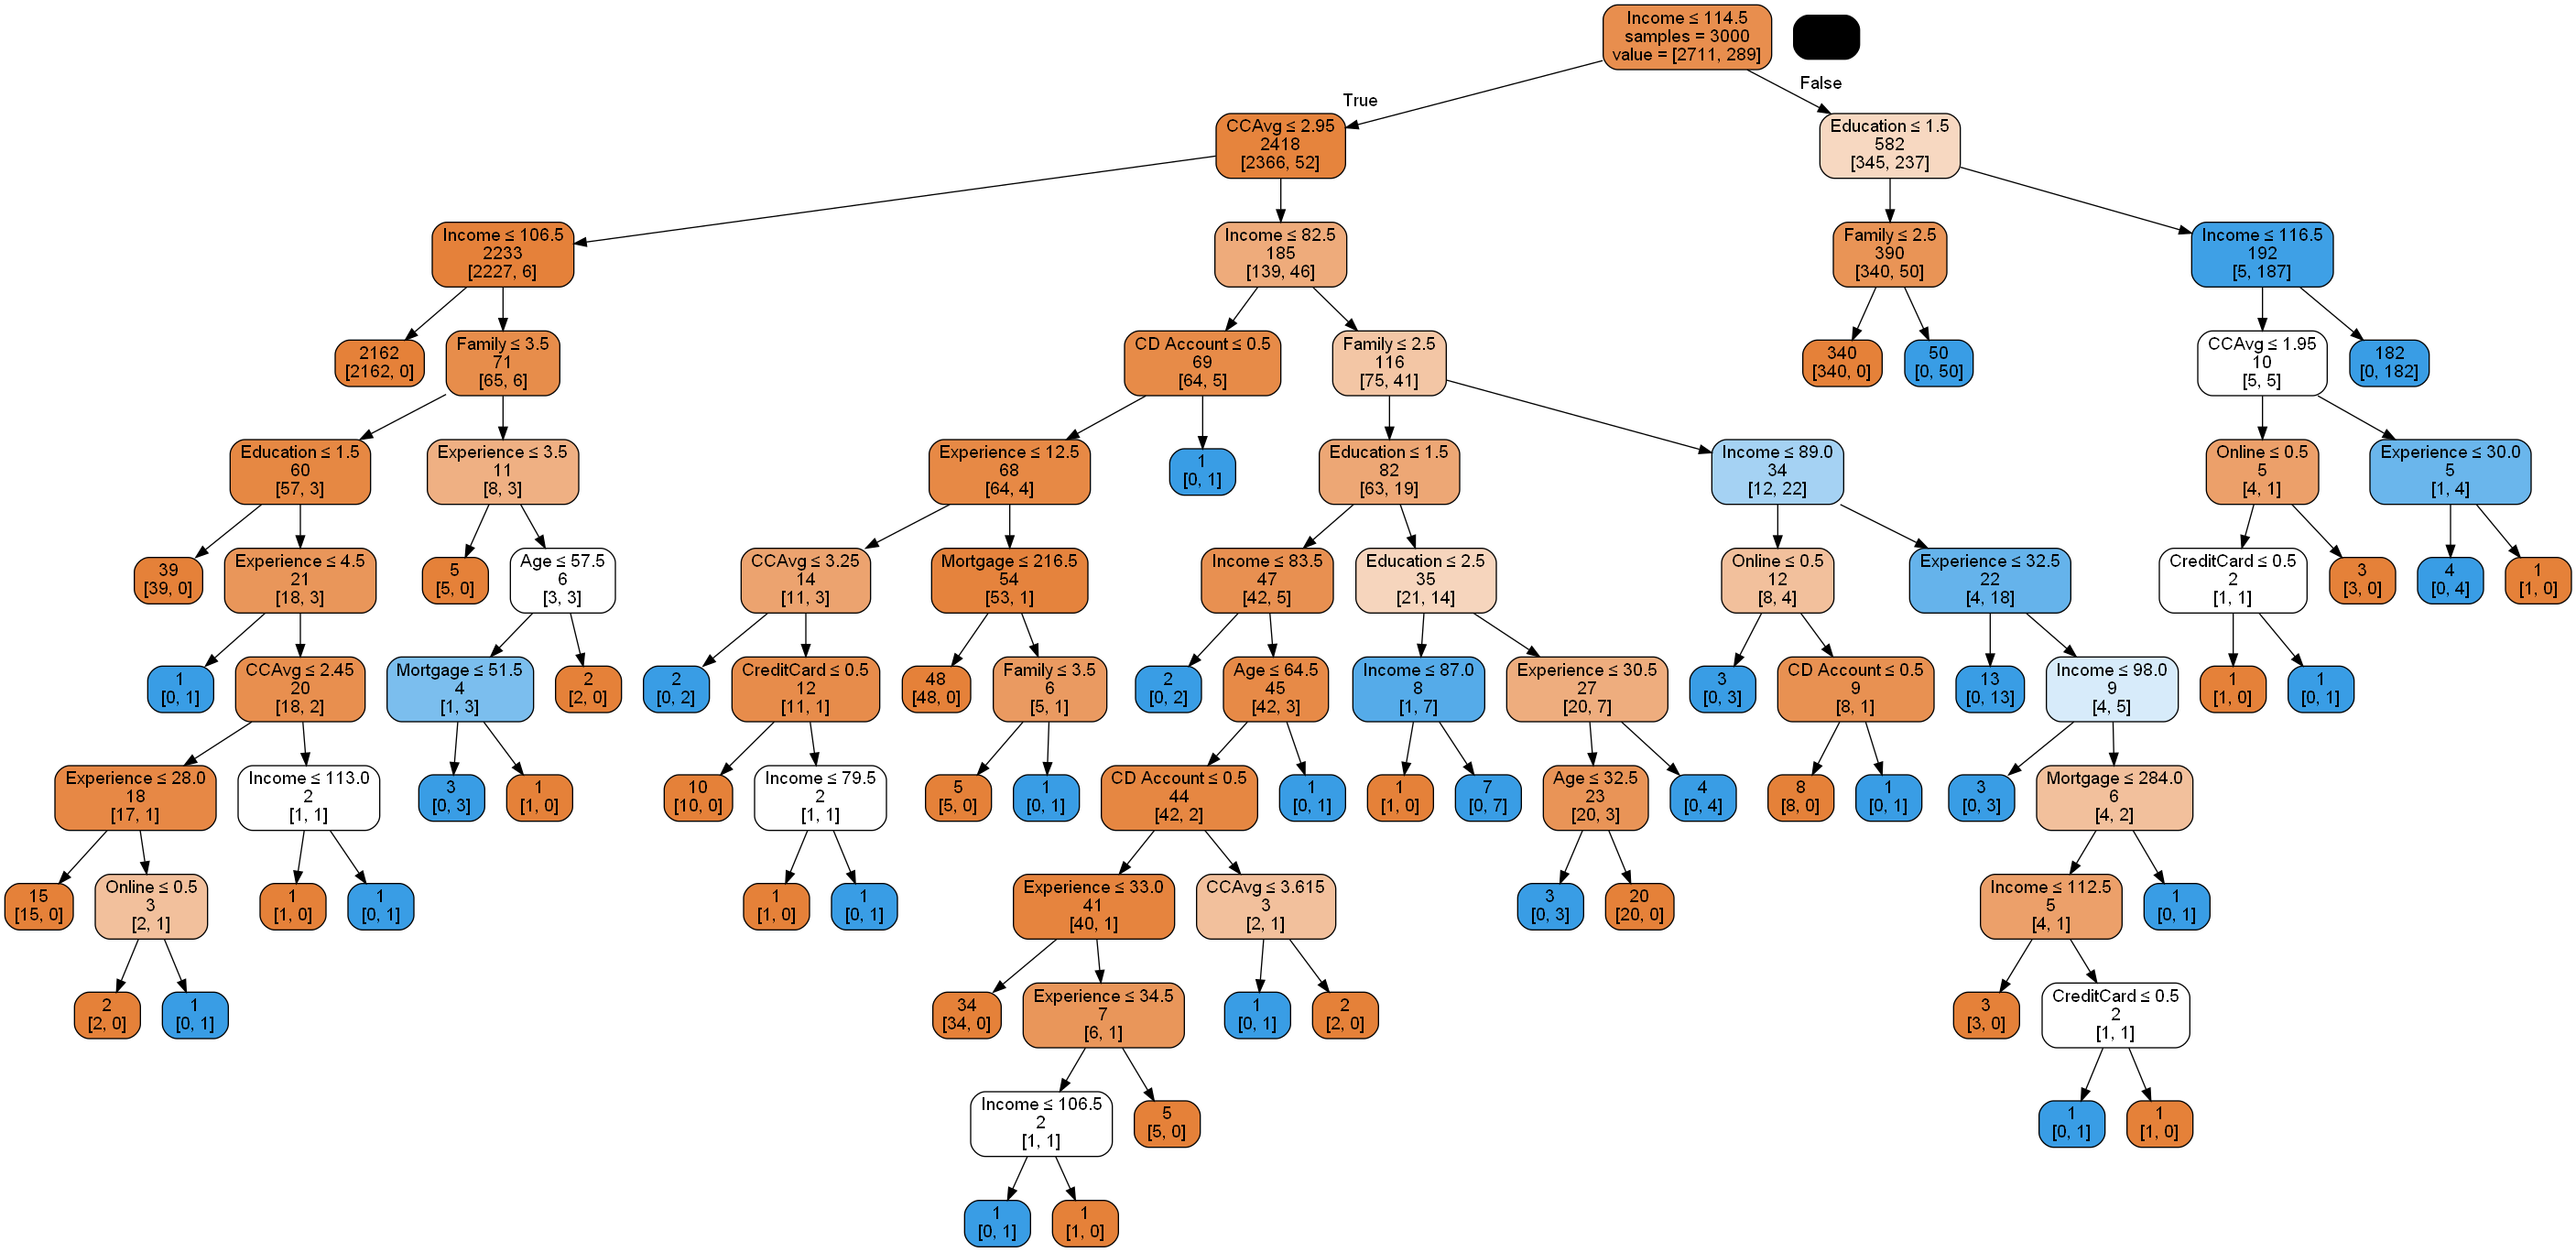

In [6]:
bank_df = pd.read_csv("../DATA/UniversalBank.csv")
bank_df.drop(columns= ['ID', 'ZIP Code'], inplace=True)
X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=8)

fullClassTree = DecisionTreeClassifier(random_state=8)
fullClassTree.fit(train_X, train_y)

plotDecisionTree(fullClassTree, feature_names=train_X.columns)

In [7]:
# Classification Summary
classificationSummary(train_y, fullClassTree.predict(train_X))
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2711    0
     1    0  289
Confusion Matrix (Accuracy 0.9830)

       Prediction
Actual    0    1
     0 1794   15
     1   19  172


In [8]:
# Computing validation accuracy using 5-fold cross-validation on the full tree
treeClassifier = DecisionTreeClassifier(random_state=8)

scores = cross_val_score(treeClassifier, train_X, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'acc:.3f' for acc in scores])

Accuracy scores of each fold:  ['acc:.3f', 'acc:.3f', 'acc:.3f', 'acc:.3f', 'acc:.3f']


## Avoiding Overfitting

### Stop Tree Growth

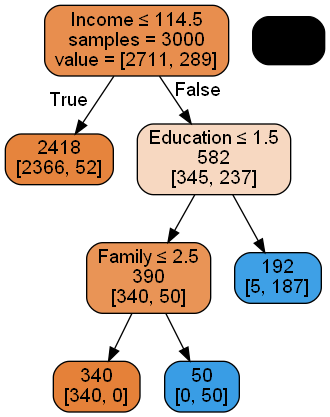

In [9]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20,
                                        min_impurity_decrease=0.01, random_state=8)
smallClassTree.fit(train_X, train_y)

plotDecisionTree(smallClassTree, feature_names=train_X.columns)

In [10]:
# confusion matrices and accuracy for the small classification tree
classificationSummary(train_y, smallClassTree.predict(train_X))
classificationSummary(valid_y, smallClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9810)

       Prediction
Actual    0    1
     0 2706    5
     1   52  237
Confusion Matrix (Accuracy 0.9800)

       Prediction
Actual    0    1
     0 1808    1
     1   39  152


### Fine-tuning Tree Parameters

In [11]:
# Using GridSearchCV to fine tune method parameters

## Start with a initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv = 5, n_jobs=-1) # n-jobs = -1 will utilize all available CPUs
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.985
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_split': 40}


In [12]:
## Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2,16)), # 14 values
    'min_samples_split': list(range(10,22)), # 11 values
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], # 3 values
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Improved score:  0.9846666666666668
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.0009, 'min_samples_split': 10}


In [13]:
# Evaluating performance of fint-tuned classification tree
## fine-tuned tree: training
classificationSummary(train_y, bestClassTree.predict(train_X))

Confusion Matrix (Accuracy 0.9857)

       Prediction
Actual    0    1
     0 2707    4
     1   39  250


In [14]:
## fine-tuned tree: validation
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9815)

       Prediction
Actual    0    1
     0 1803    6
     1   31  160


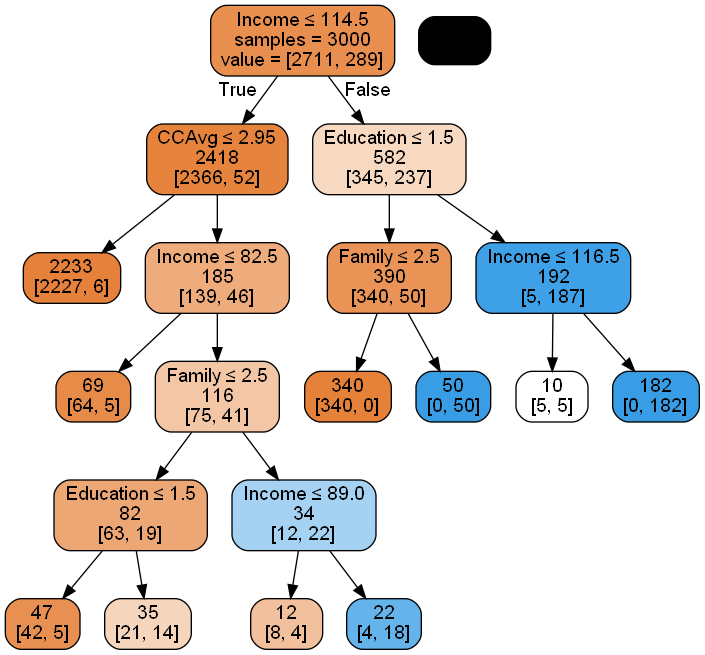

In [15]:
# Plotting the fine-tuned tree
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

### Other Methods for Limiting Tree Size

#### CHAID (Chi-squared automatic interaction detection)
CHAID stands for chi-squared automatic interaction detection, a recursive partitioning method that
predates classification and regression tree (CART) procedures by several years and is widely used in
database marketing applications to this day. It uses a well-known statistical test (the chi-square test for
independence) to assess whether splitting a node improves the purity by a statistically significant
amount. In particular, at each node, we split on the predictor with the strongest association with the
outcome variable. The strength of association is measured by the p-value of a chi-squared test of
independence. If for the best predictor the test does not show a significant improvement, the split is not
carried out, and the tree is terminated. A more general class of trees based on this idea is called
conditional inference trees (see Hothorn et al., 2006).

#### Pruning
The idea behind pruning is to recognize that a very large tree is likely to overfit the training data, and
that the smallest branches, which are the last to be grown and are furthest from the trunk, are likely
fitting noise in the training data.


# 2. Regression Tree

In [16]:
# import package and dataset
from sklearn.tree import DecisionTreeRegressor
toyotaCorolla_df = pd.read_csv("../DATA/ToyotaCorolla.csv")
toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

In [17]:
# prepare the datasets for training and test data
predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [19]:
# use grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01],
    'min_samples_split': [10, 20, 30, 40, 50],
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.005, 'min_samples_split': 10}


In [20]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.003, 0.005, 0.006, 0.007, 0.008],
    'min_samples_split': [14, 15, 16, 18, 20, ],
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 14}


In [22]:
regTree = gridSearch.best_estimator_

regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1101.0597
            Mean Absolute Error (MAE) : 800.4555
          Mean Percentage Error (MPE) : -1.0396
Mean Absolute Percentage Error (MAPE) : 7.8185

Regression statistics

                      Mean Error (ME) : 4.9461
       Root Mean Squared Error (RMSE) : 1230.7881
            Mean Absolute Error (MAE) : 943.1207
          Mean Percentage Error (MPE) : -1.2718
Mean Absolute Percentage Error (MAPE) : 9.4966


# 3. Random Forest

In [30]:
X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

               feature  importance       std
7   Securities Account    0.003964  0.004998
9               Online    0.006394  0.005350
10          CreditCard    0.007678  0.007053
6             Mortgage    0.034243  0.023469
1           Experience    0.035539  0.016061
0                  Age    0.036258  0.015858
8           CD Account    0.057917  0.043185
3               Family    0.111375  0.053146
4                CCAvg    0.172105  0.103011
5            Education    0.200772  0.101002
2               Income    0.333756  0.129227


In [31]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.9820)

       Prediction
Actual    0    1
     0 1803    4
     1   32  161


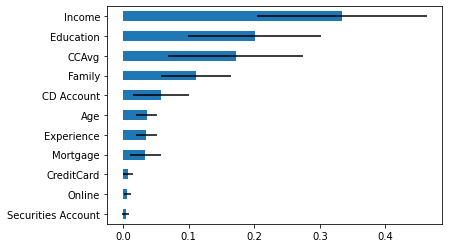

In [32]:
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()

# 4. Boosted Trees

In [33]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.9835)

       Prediction
Actual    0    1
     0 1799    8
     1   25  168


# 5. Problems